<a href="https://colab.research.google.com/github/eagomez2/mir_basics/blob/main/eagomez_assignment01_exemplary_mir_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIR assignment 01 - Basic flow in an exemplary MIR classification research task 

## Instructions
In this assignment you should understand and reproduce the instrument classification experiment presented in [this jupyter notebook](https://github.com/MTG/MIRCourse/blob/master/notebooks/Lecture1_IntroWithACaseStudy.ipynb), and then adapt the notebook to another instrument classification task, one using the [Mridangam Stroke dataset](https://zenodo.org/record/4068196). The goal is to automatically recognize the 10 different stroke classes or the 6 different tonic classes present in the dataset (you choose), trying to obtain the best possible accuracy. For both tasks you should use the whole dataset.  

The goal of the assignment is to understand and be able to implement all the steps involved in a typical audio-based classification problem. Thus, understanding all the steps involved in designing the experiment and making the best choices for a given task. You should briefly explain within the submitted notebook, all the decisions taken in every step of the experiment.  

You can optionally add a step of feature selection. Feature selection is the removal of redundancies in features, lowering the dimensionality of the feature space. Effective feature selection can improve performance of a classifier and would lower memory and computation requirements.

- Increase the number of classes to 8 (either use more classes from UIOWA:MIS dataset or continue with the Mridangam dataset)

- Add a feature selection step in the process (most critical part)

- Observe and report its contribution, discuss your observations

## About the structure of this notebook

The author has chosen to implement the necessary code for the following tasks:
1. Tonic classification of the Mridangam Stroke dataset
2. Stroke classification of the Mridangam Stroke dataset

Additionally, some techniques for **feature selection** and **class imbalance** are addressed to evaluate their impact in the aforementioned tasks.

# Installing Essentia  
Essentia is an open-source library and tools for audio and music analysis, description and synthesis whose documentation can be found [here](https://essentia.upf.edu/).

In [1]:
# Installs Essentia if it's not installed yet
import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia

     |████████████████████████████████| 12.0MB 9.0MB/s 


# Imports  
Some other dependencies that are going to be used for the different sections of this notebook.

In [193]:
import os, sys, shutil, zipfile, requests, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import essentia.standard as ess
import seaborn as sns
from tqdm.notebook import tqdm # helps to create progress bars during loops
from pathlib import Path
from IPython.display import display, Markdown

import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

# Magic functions  
Some [magic functions](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magics-explained) could be included in this section to make our notebook work nicer.

In [3]:
%matplotlib inline

# Dataset acquisition  
The code in the following sections downloads and uncompresses the Mridangam Stroke dataset, locating it inside the corresponding folder for reading and further processing of the audio files.  

The dataset is comprised of 6 tonic classes and 10 stroke classes named under the following conventions:

> StrokeName_Tonic_InstanceNumber.wav  
> Tonic = {B, C, Csh, D, Dsh, E}  
> StrokeName = {Bheem, Cha, Dheem, Dhin, Num, Ta, Tha, Tham, Thi, Thom}

Additional description about the dataset can be found [here](https://zenodo.org/record/4068196#.YBINk3dKjQg).

## Download helper function  
The following function is created in order to download the dataset appropriately.

In [4]:
def download_content(url=None, filename=None, dir='data', chunk_size=1024, unzip=False, delete_original=False, delete_postflight=[]):
  """ Downloads the dataset to a local folder, unzip it and get rids of
      unnecessary content if necessary.

      Args:
          url (str):                Link of the downloadable dataset.
          filename (str):           Name to be given to the dataset file.
          dir (str):                Folder where the dataset is stored.
          chunk_size (int):         Chunk size for the download streaming.
          unzip (bool):             Unzip after download is completed.
          delete_original (bool):   If True, deletes original file after it is uncompressed.
          delete_postflight (list): List of strings containing folders to be deleted after
              the file is downloaded and unziped.
  """
  r = requests.get(url, stream=True)

  try:
    total_size = int(r.headers['content-length'])
  except:
    total_size = chunk_size    # Content-length may be unknown if the source will only stream the file

  filepath = os.path.join(dir, filename)

  # Make folder if it does not exist
  if not os.path.exists(dir):
    os.mkdir(dir)

  # Download the content
  with open(filepath, 'wb') as file:
    for data in tqdm(iterable=r.iter_content(chunk_size=chunk_size), total=(total_size / chunk_size), unit='MB'):
      file.write(data)
    
  print(f'Content successfully downloaded to {filepath}')

  # Unzip file
  if unzip:
    print(f'Uncompressing {filename}...')
    zip_extractor = zipfile.ZipFile(filepath, 'r')
    zip_extractor.extractall(dir)
    zip_extractor.close()
    print(f'Uncompressed file saved to {dir}...')

  # Delete original folder
  if delete_original:
    print(f'Deleting original file {filepath}...')
    os.remove(filepath)

  # Delete other unnecessary folders
  if delete_postflight:
    for item in delete_postflight:
      item_path = os.path.join(dir, item)
      if os.path.exists(item_path):
        print(f'Deleting unnecessary item {item_path}')
        shutil.rmtree(item_path)

  print('Operation completed!')

## Dataset related definitions  
Some dataset related constants are stored to be used in later steps.

In [5]:
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
DATA_ROOT = os.path.join(BASE_DIR, 'data')
DATASET_URL = 'https://zenodo.org/record/4068196/files/mridangam_stroke_1.5.zip'
DATASET_NAME = os.path.splitext(os.path.basename(DATASET_URL))[0]
DATASET_ROOT = os.path.join(DATA_ROOT, DATASET_NAME)
DATASET_FS = 44100

# If true, data.csv will be obtained and therefore feature extraction
# with Essentia will not be re-computed to save some time executing this notebook.
# The dataset will still be downloaded to visualize the files.
DOWNLOAD_PRECOMPUTED_DATA = True
PRECOMPUTED_DATA_URL = 'https://drive.google.com/u/5/uc?id=1oT62rh-VOxWq5dGr6W2O5vC6t77Kl2R3&export=download'

# A dict to pattern match file names
TONIC_CLASSES = {
    '-b-':    'b',
    '-c-':    'c',
    '-csh-':  'c#',
    '-d-':    'd',
    '-dsh-':  'd#',
    '-e-':    'e',
}

STROKE_CLASSES = {
    '_bheem-':  'bheem',
    '_cha-':    'cha',
    '_dheem-':  'dheem',
    '_dhin-':   'dhin',
    '_num-':    'num',
    '_ta-':     'ta',
    '_tha-':    'tha',
    '_tham-':   'tham',
    '_thi-':    'thi',
    '_thom-':   'thom',
}

## Download the dataset  
Downloads and uncompresses the dataset at the given location. If `DOWNLOAD_PRECOMPUTED_DATA` is set to `True` in the previous cell, the file containing precomputed Essentia features will be downloaded in order to save time. In either case, the dataset will still be downloaded to compute visualizations of its content.

In [6]:
download_content(url=DATASET_URL, 
                 filename=DATASET_URL.split('/')[-1], 
                 dir=DATA_ROOT,
                 unzip=True,
                 delete_original=True,
                 delete_postflight=['__MACOSX'])

if DOWNLOAD_PRECOMPUTED_DATA:
    download_content(url=PRECOMPUTED_DATA_URL, 
                     filename='data.csv', 
                     dir=DATASET_ROOT)


Content successfully downloaded to /content/data/mridangam_stroke_1.5.zip
Uncompressing mridangam_stroke_1.5.zip...
Uncompressed file saved to /content/data...
Deleting original file /content/data/mridangam_stroke_1.5.zip...
Deleting unnecessary item /content/data/__MACOSX
Operation completed!



Content successfully downloaded to /content/data/mridangam_stroke_1.5/data.csv
Operation completed!


# Collecting information from the dataset  
Some useful information for the `tonic_class` and `stroke_class` classification tasks is extracted.

## Path mapping helper function  
This function will help to match patterns in the filepath to a key from a given `dict`, allowing to exploit dataset naming conventions to classify the data.

In [7]:
def map_path_substr(path, substr_map, default=np.NaN, use_filename=True):
    """ Maps a pattern matched in path to a key found in substr_map.

    Args:
        path (str):          The path of a file (or folder).
        substr_map (dict):   Dictionary containing key/value pairs for mapping.
        default:             Default value given to unmapped items.
        use_filename (bool): Use filename only and ignore directory.
        
    Returns:
        mapped_val (str): Mapped value obtained from the substr_map.
    """
    mapped_val = default

    if use_filename: path = Path(path).stem

    for key in substr_map.keys():
        if key in path: mapped_val = substr_map[key]

    return mapped_val

## DataFrame display helper function 
This very short function will help to visualize full-width columns when displaying `pd.DataFrames`.

In [8]:
def display_fullwidth(df):
    """ Display fullwidth DataFrame. 
    Args:
        df (pd.DataFrame): DataFrame to be displayed.
    """
    pd.set_option('display.max_colwidth', None)
    display(df)
    pd.reset_option('display.max_colwidth')


def display_all_rows(df):
    """ Display all DataFrame rows.
    Args:
        df (pd.DataFrame): DataFrame to be displayed.
    """
    pd.set_option('display.max_rows', None)
    display(df)
    pd.reset_option('display.max_rows')

## Parsing dataset file structure  
The filenames from the dataset are matched against some patterns to label their `tonic_class` and `stroke_class`. All this information is then stored in a `pd.DataFrame` object.

In [9]:
audiofiles = [os.path.join(root, file) 
              for root, dirs, files in os.walk(DATASET_ROOT) 
              for file in files if file.endswith('.wav')]

df_audiofiles = pd.DataFrame(audiofiles, columns=['filepath'])
df_audiofiles['tonic_class'] = df_audiofiles['filepath'].map(lambda filepath: map_path_substr(filepath, TONIC_CLASSES))
df_audiofiles['stroke_class'] = df_audiofiles['filepath'].map(lambda filepath: map_path_substr(filepath, STROKE_CLASSES))

display_fullwidth(df_audiofiles)

,filepath,tonic_class,stroke_class
0,/content/data/mridangam_stroke_1.5/D#/228871__akshaylaya__dhin-dsh-072.wav,d#,dhin
1,/content/data/mridangam_stroke_1.5/D#/229357__akshaylaya__tha-dsh-084.wav,d#,tha
2,/content/data/mridangam_stroke_1.5/D#/228926__akshaylaya__dhin-dsh-127.wav,d#,dhin
3,/content/data/mridangam_stroke_1.5/D#/228948__akshaylaya__dhin-dsh-148.wav,d#,dhin
4,/content/data/mridangam_stroke_1.5/D#/229791__akshaylaya__thi-dsh-228.wav,d#,thi
...,...,...,...
6972,/content/data/mridangam_stroke_1.5/D/227740__akshaylaya__cha-d-054.wav,d,cha
6973,/content/data/mridangam_stroke_1.5/D/228060__akshaylaya__tha-d-085.wav,d,tha
6974,/content/data/mridangam_stroke_1.5/D/227857__akshaylaya__ta-d-062.wav,d,ta
6975,/content/data/mridangam_stroke_1.5/D/228338__akshaylaya__thi-d-110.wav,d,thi


## Investigating and preprocessing raw data  
In the following cell, one sample is taken for each pitch class in order to get an idea about how our data looks like.

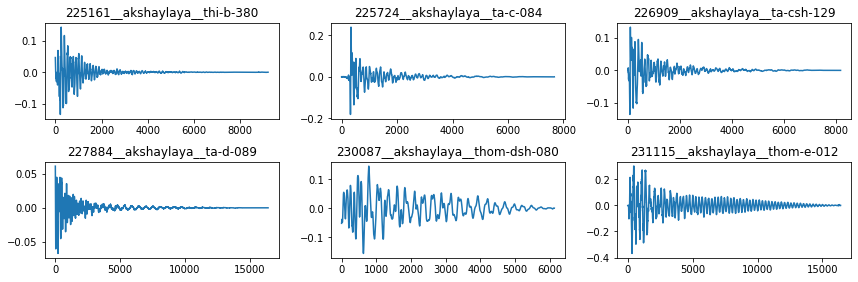

In [10]:
# Sample some files to plot (one for each tonic class)
df_sample = df_audiofiles.groupby('tonic_class')['filepath'] \
                         .apply(lambda group: group.sample(n=1, random_state=1))

# plot each sample
plt.figure(figsize=(2 * len(TONIC_CLASSES), 4))

for idx, sample_file in enumerate(df_sample):
    x = ess.MonoLoader(filename=sample_file, sampleRate=DATASET_FS)()

    plt.subplot(2, 3, (idx + 1))
    plt.plot(x)
    plt.tight_layout(pad=1.0)
    plt.title(Path(sample_file).stem)

As it can be observed, all files contain a single stroke and therefore there is no need to segment data as it may occur with other datasets where several audio chunks that are supposed to be analyzed separately are grouped in a single file. In the next session, feature extraction will be then performed.

# Feature extraction  
Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. Let's first run it for a single file and check its output:

In [11]:
sample_file = df_audiofiles['filepath'][0]  # Pick first file in the list

features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                               lowlevelFrameSize=2048,
                                               lowlevelHopSize=1024,
                                               lowlevelStats=['mean', 'stdev'])(sample_file)

## Extract descriptor names
`essentia.MusicExtractor` extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [12]:
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() 
                              if 'lowlevel' in descriptor and
                              isinstance(features[descriptor], float)]

df_scalar_lowlevel_descriptors = pd.DataFrame(scalar_lowlevel_descriptors, columns=['scalar_lowlevel_descriptors'])
display_all_rows(df_scalar_lowlevel_descriptors)

,scalar_lowlevel_descriptors
0,lowlevel.average_loudness
1,lowlevel.barkbands_crest.mean
2,lowlevel.barkbands_crest.stdev
3,lowlevel.barkbands_flatness_db.mean
4,lowlevel.barkbands_flatness_db.stdev
5,lowlevel.barkbands_kurtosis.mean
6,lowlevel.barkbands_kurtosis.stdev
7,lowlevel.barkbands_skewness.mean
8,lowlevel.barkbands_skewness.stdev
9,lowlevel.barkbands_spread.mean


## Extract features of all files  
Let's run `essentia.MusicExtractor` for all files, keeping a subset of features, writting to an output file `data.csv`.  

**Important:** In order to save time while executing this notebook, a file of precomputed features can be downloaded if `DOWNLOAD_PRECOMPUTED_DATA` is set to `True` in the **Dataset related definitions** cell, otherwise features will be computed and stored on the fly.

In [13]:
def perform_feature_extraction(df_audiofiles=None, feature_set=[], output_file=None):
    """ Given a feature set, performs feature extraction in bulk.
        
        Perform feature extraction in all files in df_audiofiles DataFrame. Only
        features in feature_set will be stored in output_file. While files are
        being processed, a progress bar will be shown.
        Files raising and Exception during the feature extraction process will 
        be ignored.

    Args:
        df_audiofiles (pd.DataFrame): DataFrame containing the list of files to be processed.
        feature_set (list): A list containing the feature set to be extracted.
        output_file (str): A path to the file where features will be written.
    """
    file_count = 0          # Counts the number of processed files.
    ignored_file_count = 0  # Counts the number of ignored processed files.

    with open(output_file, 'w') as writer:
        column_names = ','.join(scalar_lowlevel_descriptors + \
                                ['tonic_class'] + ['stroke_class']).replace('lowlevel.', '') + '\n'
        writer.write(column_names)

    iterator = tqdm(df_audiofiles.iterrows())
    iterator.set_description('Extracting audio file features\n')
    
    for idx, audio_file in iterator:
        file_count += 1

        if file_count % 20 == 0:  # Reports progress every 20 files
            iterator.set_postfix_str(f'File: {audio_file.filepath}')

        try:
            features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                    lowlevelFrameSize=2048,
                                                    lowlevelHopSize=1024,
                                                    lowlevelStats=['mean', 'stdev'])(audio_file.filepath)
        
            selected_features = [features[feature] for feature in feature_set]
            line2write = str(selected_features)[1:-1] + ',' + audio_file.tonic_class + ',' + audio_file.stroke_class + '\n'
            writer.write(line2write)
        
        except Exception:
            ignored_file_count += 1

    print(f'Total files: {file_count} / ignored files: {ignored_file_count}')

In [14]:
%%time
data_file = os.path.join(DATASET_ROOT, 'data.csv')

if not DOWNLOAD_PRECOMPUTED_DATA:
    perform_feature_extraction(df_audiofiles=df_audiofiles, feature_set=scalar_lowlevel_descriptors, output_file=data_file)
else:
    print('Precomputed data has been already downloaded (DOWNLOAD_PRECOMPUTED_DATA=True)')

Precomputed data has been already downloaded (DOWNLOAD_PRECOMPUTED_DATA=True)
CPU times: user 515 µs, sys: 0 ns, total: 515 µs
Wall time: 522 µs


# Feature preprocessing and analysis  
First the raw data file stored at `data_file` will be loaded into a `pd.DataFrame` and inspected to see how it looks like.

In [15]:
df_raw = pd.read_csv(data_file)
display(df_raw.head())

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,barkbands_spread.stdev,dissonance.mean,dissonance.stdev,dynamic_complexity,erbbands_crest.mean,erbbands_crest.stdev,erbbands_flatness_db.mean,erbbands_flatness_db.stdev,erbbands_kurtosis.mean,erbbands_kurtosis.stdev,erbbands_skewness.mean,erbbands_skewness.stdev,erbbands_spread.mean,erbbands_spread.stdev,hfc.mean,hfc.stdev,loudness_ebu128.integrated,loudness_ebu128.loudness_range,loudness_ebu128.momentary.mean,loudness_ebu128.momentary.stdev,loudness_ebu128.short_term.mean,loudness_ebu128.short_term.stdev,melbands_crest.mean,melbands_crest.stdev,melbands_flatness_db.mean,melbands_flatness_db.stdev,melbands_kurtosis.mean,melbands_kurtosis.stdev,melbands_skewness.mean,melbands_skewness.stdev,...,silence_rate_30dB.mean,silence_rate_30dB.stdev,silence_rate_60dB.mean,silence_rate_60dB.stdev,spectral_centroid.mean,spectral_centroid.stdev,spectral_complexity.mean,spectral_complexity.stdev,spectral_decrease.mean,spectral_decrease.stdev,spectral_energy.mean,spectral_energy.stdev,spectral_energyband_high.mean,spectral_energyband_high.stdev,spectral_energyband_low.mean,spectral_energyband_low.stdev,spectral_energyband_middle_high.mean,spectral_energyband_middle_high.stdev,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.stdev,spectral_entropy.mean,spectral_entropy.stdev,spectral_flux.mean,spectral_flux.stdev,spectral_kurtosis.mean,spectral_kurtosis.stdev,spectral_rms.mean,spectral_rms.stdev,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,tonic_class,stroke_class
0,0.990684,13.143802,3.646803,0.270179,0.033385,7.246653,8.834133,1.345190,1.078246,5.394475,1.607681,0.358553,0.061417,0.000000,20.195524,4.523904,0.268212,0.051030,3.776634,4.045100,1.296078,0.981894,10.574745,2.464276,8.035463,14.744556,-37.513039,0.0,-37.513039,0.000000,-46.263657,0.0,16.674971,4.315648,0.401925,0.046120,3.863402,3.658890,1.169969,0.549256,...,1.0,0.0,0.625000,0.484123,408.462097,123.224274,3.875000,4.342738,-3.534134e-09,5.684780e-09,0.014067,0.022761,0.000004,0.000010,0.001023,0.001429,0.003932,0.008322,0.009478,0.014652,6.102621,0.376377,0.081164,0.088839,46.515633,19.048918,0.002373,0.002845,489.880371,258.790680,5.366868,1.115183,2156334.0,1526993.25,0.543809,0.744391,0.018799,0.003266,c#,ta
1,0.990684,16.743053,3.136686,0.437948,0.123609,188.159103,199.721588,8.164556,5.853784,3.144379,4.528781,0.343280,0.081297,16.797049,18.872656,5.399826,0.268716,0.109515,36.267605,48.094067,3.561029,3.099530,19.231237,30.582209,1.609933,5.288309,-30.804411,0.0,-47.833351,12.462303,-36.725075,0.0,24.696627,3.377652,0.594787,0.142343,86.690926,118.459396,3.646239,3.724990,...,1.0,0.0,0.838710,0.367799,189.536331,140.517410,1.483871,2.757640,-1.636785e-09,5.111101e-09,0.006324,0.019769,0.000009,0.000049,0.003562,0.010274,0.000068,0.000282,0.003203,0.010934,5.226341,1.147376,0.027045,0.062139,54.848545,47.567142,0.001163,0.002195,154.205521,95.378120,5.777487,2.943947,4417231.0,3438656.75,0.127013,0.232824,0.015026,0.014807,c#,tham
2,0.990684,14.683802,4.751857,0.203608,0.063099,15.669172,13.897552,2.524112,1.284726,15.567714,15.293839,0.423821,0.048364,0.000000,21.500511,6.234387,0.204433,0.074896,11.021485,9.408529,2.534967,1.340115,16.837044,15.560231,4.800261,15.112673,-39.541683,0.0,-39.541679,0.000000,-48.292297,0.0,18.082329,5.606548,0.310182,0.093872,9.759953,5.266310,1.477734,0.813174,...,1.0,0.0,0.812500,0.390312,462.769440,136.381699,2.375000,4.512136,-2.235877e-09,6.470807e-09,0.008874,0.025785,0.000057,0.000221,0.000578,0.001879,0.001419,0.004917,0.007004,0.019573,6.551918,0.689452,0.045652,0.090099,23.661066,15.750944,0.001252,

It is always good to check for `Nan` values that may imply incomplete rows that need to be handed accordingly depending on our task. If no `Nan` values are found, we are good to move to the next step.

In [16]:
nan_values = df_raw.isnull().sum().sum()
print(f'{nan_values} Nan values found')

0 Nan values found


## Data visualization  
It is always a good idea to inspect the data visually in order to observe what features are more useful for our tasks. Visualizing features can give an idea about how our data is distributed and by plotting feature pairs, we can observe the relationship between different descriptors. Let's first pick 2 features and plot an example using the `Seaborn` library.

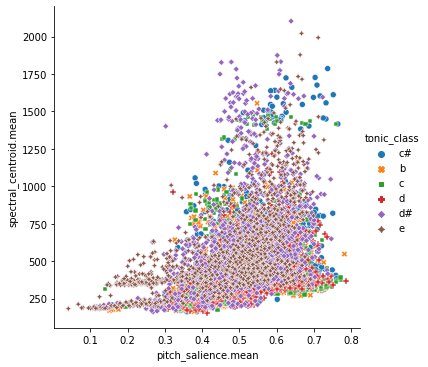

In [17]:
sns.relplot(x='pitch_salience.mean', y ='spectral_centroid.mean', hue='tonic_class', style='tonic_class', data=df_raw)
plt.show()

Now let's plot a selected number of features to have a better idea about how our dataset looks like and what can be useful for our first classification task with the goal of classifying by `tonic_class`. Some features that *a priori* seem informative for our task have been plotted, although any other feature can be plotted by adding ot to the `features_to_plot` list.

CPU times: user 20.7 s, sys: 307 ms, total: 21 s
Wall time: 20.8 s


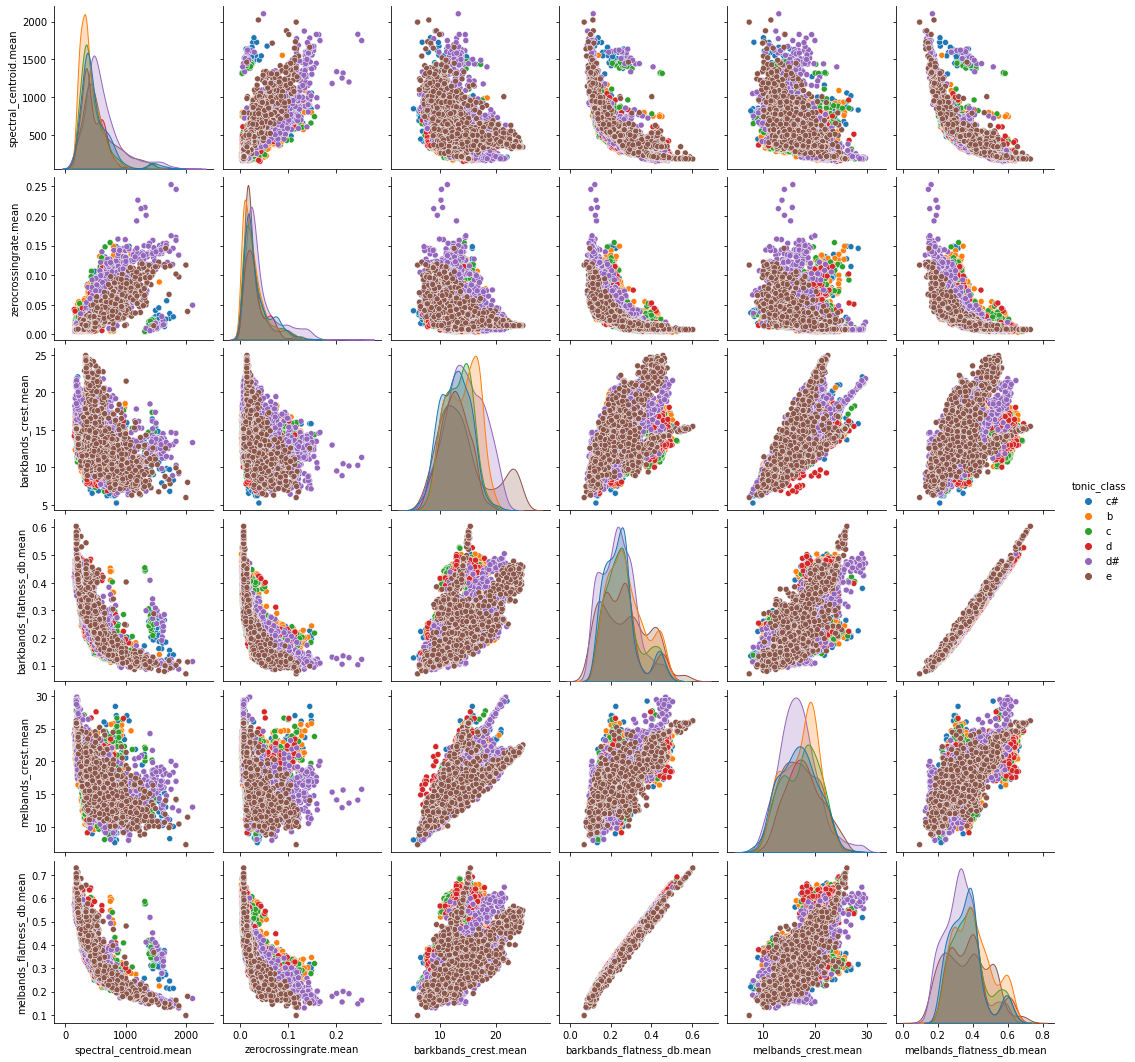

In [18]:
%%time
features_to_plot = ['spectral_centroid.mean',
                    'zerocrossingrate.mean',
                    'barkbands_crest.mean',
                    'barkbands_flatness_db.mean',
                    'melbands_crest.mean',
                    'melbands_flatness_db.mean',
                    'tonic_class']

sns.pairplot(df_raw[features_to_plot], hue='tonic_class')

## Simple data statistics  
Some simple statistic calculations along with the visualization of our data can greatly help to decide what features may be redundant to use or do not vary much in our dataset.  

**Observation:** `min`, `max` and `mean` values of the features vary a lot, we need to normalise them. Some of the features - such as `average_loudness` - may be irrelevant for the task.

In [19]:
df_raw.describe()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,barkbands_spread.stdev,dissonance.mean,dissonance.stdev,dynamic_complexity,erbbands_crest.mean,erbbands_crest.stdev,erbbands_flatness_db.mean,erbbands_flatness_db.stdev,erbbands_kurtosis.mean,erbbands_kurtosis.stdev,erbbands_skewness.mean,erbbands_skewness.stdev,erbbands_spread.mean,erbbands_spread.stdev,hfc.mean,hfc.stdev,loudness_ebu128.integrated,loudness_ebu128.loudness_range,loudness_ebu128.momentary.mean,loudness_ebu128.momentary.stdev,loudness_ebu128.short_term.mean,loudness_ebu128.short_term.stdev,melbands_crest.mean,melbands_crest.stdev,melbands_flatness_db.mean,melbands_flatness_db.stdev,melbands_kurtosis.mean,melbands_kurtosis.stdev,melbands_skewness.mean,melbands_skewness.stdev,...,silence_rate_20dB.mean,silence_rate_20dB.stdev,silence_rate_30dB.mean,silence_rate_30dB.stdev,silence_rate_60dB.mean,silence_rate_60dB.stdev,spectral_centroid.mean,spectral_centroid.stdev,spectral_complexity.mean,spectral_complexity.stdev,spectral_decrease.mean,spectral_decrease.stdev,spectral_energy.mean,spectral_energy.stdev,spectral_energyband_high.mean,spectral_energyband_high.stdev,spectral_energyband_low.mean,spectral_energyband_low.stdev,spectral_energyband_middle_high.mean,spectral_energyband_middle_high.stdev,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.stdev,spectral_entropy.mean,spectral_entropy.stdev,spectral_flux.mean,spectral_flux.stdev,spectral_kurtosis.mean,spectral_kurtosis.stdev,spectral_rms.mean,spectral_rms.stdev,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev
count,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.0,6977.000000,6977.000000,6977.000000,6977.0,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,...,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6.977000e+03,6.977000e+03,6977.000000,6977.000000,6.977000e+03,6.977000e+03,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6.977000e+03,6.977000e+03,6977.000000,6977.000000,6977.000000,6977.000000
mean,0.990642,13.675754,3.986220,0.257629,0.062161,45.245765,47.685512,3.086854,2.161348,9.176358,7.029981,0.363517,0.066882,3.808935,13.932424,4.766604,0.227526,0.063417,10.637650,9.907982,1.666093,1.100477,19.027462,13.769547,5.001198,12.778643,-35.116758,0.0,-39.172391,3.282684,-43.533357,0.0,17.113910,4.659779,0.370113,0.073738,26.944791,32.963134,2.408183,1.638852,...,0.999879,0.000563,0.997414,0.008734,0.738497,0.415193,506.352340,253.191785,3.002760,4.406861,-2.697766e-09,6.266922e-09,0.010636,0.024799,3.682611e-05,1.290387e-04,0.002226,0.005122,0.001411,0.004004,0.007544,0.017403,6.357183,0.690235,0.052539,0.084446,30.023163,16.108676,0.001681,0.002615,790.053846,908.828199,4.094878,1.125082,4.534190e+06,3.466625e+06,0.308544,0.473434,0.033649,0.018373
std,0.003487,3.305602,1.312309,0.093438,0.027913,119.084121,120.238367,2.621013,2.138012,8.830958,6.936403,0.057338,0.023507,6.338580,3.986627,1.662417,0.069986,0.020193,18.348422,15.927816,1.170643,0.742111,11.521891,9.122034,2.825798,10.239004,6.205350,0.0,9.395574,5.491493,6.277025,0.0,3.587391,1.606418,0.110407,0.033696,33

## Preprocessing the features  
Now that we have a little more information about how the raw data looks like, it's time to perform some preprocessing steps in order to make it more suitable for classification tasks. First, the data will be **normalized** using the `MinMaxScaler` class from `sklearn`. Multiple version or different sequences of steps in the raw data may be needed for other tasks, thus, `df_raw` (our raw data) will be first copied and than the normalization process will be applied to the copy. Moreover, this copy of the data will be named `df_tonic_norm` to clearly identify that it is related with the **tonic classification** task and that is normalized.

In [128]:
df_tonic_norm = df_raw.copy()
min_max_scaler = MinMaxScaler()
df_tonic_norm.iloc[:, :-2] = min_max_scaler.fit_transform(df_tonic_norm.iloc[:, :-2])  # Last 2 columns are categorical data

df_tonic_norm.describe()  # See stats again to see how it looks like after transform

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,barkbands_spread.stdev,dissonance.mean,dissonance.stdev,dynamic_complexity,erbbands_crest.mean,erbbands_crest.stdev,erbbands_flatness_db.mean,erbbands_flatness_db.stdev,erbbands_kurtosis.mean,erbbands_kurtosis.stdev,erbbands_skewness.mean,erbbands_skewness.stdev,erbbands_spread.mean,erbbands_spread.stdev,hfc.mean,hfc.stdev,loudness_ebu128.integrated,loudness_ebu128.loudness_range,loudness_ebu128.momentary.mean,loudness_ebu128.momentary.stdev,loudness_ebu128.short_term.mean,loudness_ebu128.short_term.stdev,melbands_crest.mean,melbands_crest.stdev,melbands_flatness_db.mean,melbands_flatness_db.stdev,melbands_kurtosis.mean,melbands_kurtosis.stdev,melbands_skewness.mean,melbands_skewness.stdev,...,silence_rate_20dB.mean,silence_rate_20dB.stdev,silence_rate_30dB.mean,silence_rate_30dB.stdev,silence_rate_60dB.mean,silence_rate_60dB.stdev,spectral_centroid.mean,spectral_centroid.stdev,spectral_complexity.mean,spectral_complexity.stdev,spectral_decrease.mean,spectral_decrease.stdev,spectral_energy.mean,spectral_energy.stdev,spectral_energyband_high.mean,spectral_energyband_high.stdev,spectral_energyband_low.mean,spectral_energyband_low.stdev,spectral_energyband_middle_high.mean,spectral_energyband_middle_high.stdev,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.stdev,spectral_entropy.mean,spectral_entropy.stdev,spectral_flux.mean,spectral_flux.stdev,spectral_kurtosis.mean,spectral_kurtosis.stdev,spectral_rms.mean,spectral_rms.stdev,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev
count,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.0,6977.000000,6977.000000,6977.000000,6977.0,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,...,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000
mean,0.999857,0.428361,0.371957,0.350488,0.306577,0.031940,0.032649,0.129658,0.098019,0.095967,0.115680,0.620516,0.235874,0.123934,0.388637,0.405096,0.405695,0.358120,0.048871,0.057331,0.210556,0.173190,0.200855,0.247804,0.076699,0.039585,0.600846,0.0,0.652426,0.159434,0.582996,0.0,0.437152,0.353158,0.431467,0.296184,0.036997,0.015593,0.273187,0.083537,...,0.998182,0.002257,0.989656,0.020169,0.774521,0.830387,0.181330,0.073886,0.226380,0.312792,0.879353,0.066804,0.120627,0.062746,0.027988,0.015190,0.049137,0.045711,0.036838,0.023759,0.157204,0.080527,0.621290,0.336170,0.235226,0.257737,0.148176,0.107804,0.219600,0.216806,0.048825,0.098792,0.266256,0.204329,0.209979,0.247035,0.188917,0.101915,0.120709,0.104837
std,0.011972,0.168168,0.141964,0.175007,0.150401,0.083980,0.082946,0.093542,0.106599,0.095958,0.118615,0.183590,0.098095,0.206242,0.156463,0.159493,0.163684,0.138374,0.078715,0.094546,0.120478,0.130748,0.133952,0.175106,0.048956,0.038935,0.147002,0.0,0.160758,0.266712,0.142407,0.0,0.159202,0.145934,0.174418,0.136086,0.045449,0.025892,0.105159,0.065667,...,0.036401,0.042990,0.064065,0

Now that data has been normalized, we can move ahead and see if there is any potential data imbalance problem and in such case, use some technique to overcome this issue.

## Data distribution plot helper function  
A simple function will be defined to be reused in later situations where a visualization of how our data is distributed can be useful.

In [21]:
def plot_class_distribution_barplot(df_class):
    """" Generates a bar plot including each class on df_class. 
    
    Args:
        df_class (Series): Series of the target class.
    """
    class_distribution = df_class.value_counts()

    value_counts_plot = class_distribution.plot(kind='bar')


    for bar in value_counts_plot.patches:
        value_counts_plot.annotate(bar.get_height(),  
                                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='center', 
                                   size=9, xytext=(0, 4), 
                                   textcoords='offset points')
    
    value_counts_plot.set_title(f'Amount of instances per {df_class.name}')
    value_counts_plot.set_xlabel(f'{df_class.name}')
    value_counts_plot.set_ylabel('instances')
    plt.show()

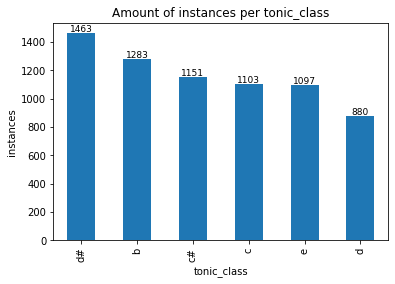

In [105]:
plot_class_distribution_barplot(df_tonic_norm.tonic_class)

**Observation**: The data is imbalanced. Several techniques can be applied such as oversampling or undersampling to have a similar amount of instances per class. We don't want to loose data of the most populated classes and therefore a a combination of oversampling called [SMOTETomek](https://imbalanced-learn.org/stable/generated/imblearn.combine.SMOTETomek.html) using SMOTE and cleaning using Tomek links will be utilized. 

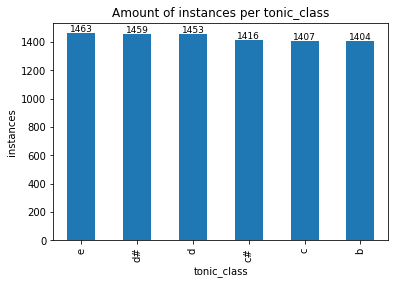

In [170]:
smk = SMOTETomek(random_state=1)  # Undersampling algorithm

df_X_tonic_norm = df_tonic_norm.drop(['tonic_class', 'stroke_class'], axis=1)
df_y_tonic_norm = df_tonic_norm[['tonic_class']]
df_y_tonic_norm.tonic_class = pd.Categorical(df_y_tonic_norm.tonic_class)

# Get undersampled data as np.array
X_tonic_norm_bal, y_tonic_norm_bal = smk.fit_sample(df_X_tonic_norm, df_y_tonic_norm)

# Reconstruct DataFrame for plotting
df_tonic_norm_bal = pd.concat([pd.DataFrame(X_tonic_norm_bal),
                                   pd.DataFrame(y_tonic_norm_bal)],
                                   axis=1)

df_tonic_norm_bal.columns = df_tonic_norm.drop(['stroke_class'], axis=1).columns

plot_class_distribution_barplot(df_tonic_norm_bal.tonic_class)

# Categorical data
`tonic_class` column should be turned into categorical data, this way it can be fed to a classifier.

**Observation**: `tonic_class` is not ordered and therefore `ordered` is set to `None` (it is the default value, but have been made explicit). Other classification tasks may imply order in their categorical data, in which case a list with the label's order may be passed to `pd.Categorical` along with setting `oredered` to `True`.

In [171]:
df_tonic_norm_bal.tonic_class = pd.Categorical(df_tonic_norm_bal.tonic_class, ordered=None)
df_tonic_norm_bal.tonic_class.dtype  # The column have been turned into a categorical dtype

CategoricalDtype(categories=['b', 'c', 'c#', 'd', 'd#', 'e'], ordered=False)

## Testing a classifier  
Now that the data is ready to train a classifier, a `svm.SVC` from `sklearn` will be trained using a test/train split of 0.33 as an example.

In [195]:
X_tonic_norm_bal = df_tonic_norm_bal.drop(['tonic_class'], axis=1).values
y_tonic_norm_bal =  np.array(df_tonic_norm_bal.tonic_class.cat.codes)

# Kind of a behemoth line but it follows PEP8, I swear!
(X_tonic_norm_bal_train, X_tonic_norm_bal_test, 
y_tonic_norm_bal_train, y_tonic_norm_bal_test) = train_test_split(X_tonic_norm_bal, 
                                                                  y_tonic_norm_bal, 
                                                                  test_size=0.33,
                                                                  random_state=1)

clf_tonic_example = SVC(gamma=1 / (X_tonic_norm_bal_train.shape[-1]) * X_tonic_norm_bal_train.var())
clf_tonic_example.fit(X_tonic_norm_bal_train, y_tonic_norm_bal_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0008983731015002195,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

## Testing the model  
Now that the model is trained, a basic testing will be performed.